# erddapy: a python client/URL builder for ERDDAP

ERDDAP has RESTful API that is very convenient for creating web apps, data portals, etc. However, writing those URLs manually can be tedious and error prone

This notebook walks through an easy to set up ERDDAP RESTful URL by using the python client, `erddapy`.

A typical ERDDAP RESTful URL looks like:

[https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=2016-07-10T00:00:00Z&time<=2017-02-10T00:00:00Z &latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0](https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=2016-07-10T00:00:00Z&time<=2017-02-10T00:00:00Z&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0)

Let's break it down to smaller parts:

- **server**: https://data.ioos.us/gliders/erddap/
- **protocol**: tabledap
- **dataset_id**: whoi_406-20160902T1700
- **response**: .mat
- **variables**: depth,latitude,longitude,temperature,time
- **constraints**:
    - time>=2016-07-10T00:00:00Z
    - time<=2017-02-10T00:00:00Z
    - latitude>=38.0
    - latitude<=41.0
    - longitude>=-72.0
    - longitude<=-69.0

We can represent that easily in Python like in the cell below.

In [1]:
server = 'https://data.ioos.us/gliders/erddap'

protocol = 'tabledap'

dataset_id = 'whoi_406-20160902T1700'

response = 'mat'

variables = [
 'depth',
 'latitude',
 'longitude',
 'salinity',
 'temperature',
 'time',
]

constraints = {
    'time>=': '2016-07-10T00:00:00Z',
    'time<=': '2017-02-10T00:00:00Z',
    'latitude>=': 38.0,
    'latitude<=': 41.0,
    'longitude>=': -72.0,
    'longitude<=': -69.0,
}

Feeding these variables in the `erddapy.ERDDAP` class we will create the URL builder object.

In [2]:
from erddapy import ERDDAP


e = ERDDAP(
    server=server,
    dataset_id=dataset_id,
    constraints=constraints,
    variables=variables,
    protocol=protocol,
    response=response,
)

print(e.get_download_url())

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0


If we change the response to `html` we can visualize the page.

In [3]:
def show_iframe(src):
    from IPython.display import HTML
    iframe = '<iframe src="{src}" width="100%" height="950"></iframe>'.format
    return HTML(iframe(src=src))

show_iframe(e.get_download_url(response='html'))

Additionally, the object has `.get_info_url()` and `.get_search_url()` that can be used to obtain the info and search URLs respectively

In [4]:
show_iframe(e.get_info_url(response='html'))

In [5]:
show_iframe(e.get_search_url(response='html'))

`erddapy` also brings some simple methods to download the data in some common data formats, like `pandas.DataFrame` and `xarray.Dataset`.

In [6]:
df = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()


df.head()

,depth,latitude,longitude,salinity,temperature
time,,,,,
2016-09-03 20:15:46,5.35,40.990881,-71.12439,32.245422,20.6620
2016-09-03 20:15:46,6.09,40.990881,-71.12439,32.223183,20.6512
2016-09-03 20:15:46,6.72,40.990881,-71.12439,32.237950,20.6047
2016-09-03 20:15:46,7.37,40.990881,-71.12439,32.235470,20.5843
2016-09-03 20:15:46,8.43,40.990881,-71.12439,32.224503,20.5691


In [7]:
ds = e.to_xarray(decode_times=False)

ds['temperature']

<xarray.DataArray 'temperature' (row: 48490)>
array([20.662 , 20.6512, 20.6047, ..., 18.9417, 19.0459, 19.2737],
      dtype=float32)
Coordinates:
    depth      (row) float32 ...
    latitude   (row) float64 ...
    longitude  (row) float64 ...
    time       (row) float64 ...
Dimensions without coordinates: row
Attributes:
    _ChunkSizes:          73
    actual_range:         [ 9.9473 22.6177]
    ancillary_variables:  qartod_temperature_climatological_flag qartod_tempe...
    colorBarMaximum:      32.0
    colorBarMinimum:      0.0
    instrument:           instrument_ctd
    ioos_category:        Temperature
    long_name:            Sea Water Temperature
    observation_type:     measured
    platform:             platform
    standard_name:        sea_water_temperature
    units:                Celsius
    valid_max:            40.0
    valid_min:            -5.0

Here is a simple plot using the data from `xarray`.

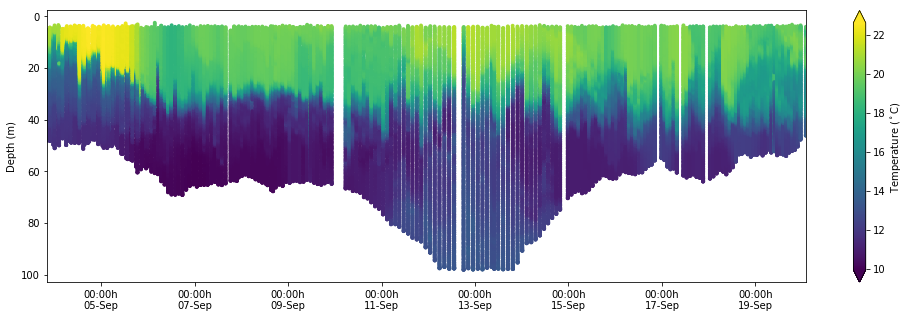

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(17, 5))
kw = dict(s=15, c=df['temperature'], marker='o', edgecolor='none')
cs = ax.scatter(df.index, df['depth'], **kw)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

One can build the proper variables programmatically, feed them in erddapy, and then build a service like [this notebook](https://mybinder.org/v2/gh/ioos/BioData-Training-Workshop/master?filepath=notebooks/ERDDAP_timeseries_explorer-IOOS.ipynb). However, erddapy is also designed for interactive work. One can explore interactively the ERDDAP server from Python.

PS: Note that in this example below we did not feed any variables other than the server URL

In [9]:
import pandas as pd
from erddapy import ERDDAP


e = ERDDAP(
    server='https://data.ioos.us/gliders/erddap'
)

df = pd.read_csv(e.get_search_url(response='csv', search_for='all'))

In [10]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 392 tabledap, 0 griddap, and 0 wms endpoints.'

We can refine our search by adding some constraints.

In [11]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -72.0,
    'max_lon': -69.0,
    'min_lat': 38.0,
    'max_lat': 41.0,
    'min_time': '2016-07-10T00:00:00Z',
    'max_time': '2017-02-10T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [12]:
search_url = e.get_search_url(response='csv', **kw)
search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

msg = 'Found {} Glider Datasets:\n\n{}'.format
print(msg(len(gliders), '\n'.join(gliders)))

Found 17 Glider Datasets:

alldrudnickGliders
blue-20160818T1448
cp_335-20170116T1459
cp_336-20161011T0027
cp_336-20170116T1254
cp_340-20160809T0230
cp_374-20160529T0035
cp_374-20161011T0106
cp_376-20160527T2050
cp_379-20170116T1246
cp_380-20161011T2046
cp_387-20160404T1858
cp_388-20160809T1409
cp_389-20161011T2040
silbo-20160413T1534
sp022-20170209T1616
whoi_406-20160902T1700


Last but not least we can inspect a specific `dataset_id`.

In [13]:
print(gliders[0])

info_url = e.get_info_url(dataset_id=gliders[0], response='csv')
info = pd.read_csv(info_url)

info.head()

alldrudnickGliders


,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgment,String,This deployment supported by NOAA.
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"profile_id, time, latitude, longitude, time_uv..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory, wmo_id"
4,attribute,NC_GLOBAL,contributor_name,String,Bob Simons (bob.simons@noaa.gov)


With the info URL we can filter the data using attributes.

In [14]:
cdm_profile_variables = info.loc[
    info['Attribute Name'] == 'cdm_profile_variables', 'Variable Name'
]

print(''.join(cdm_profile_variables))

NC_GLOBAL


In fact, that is such a common operation that `erddapy` brings its own method for filtering data by attributes. In the next three cells we request the variables names that has a `cdm_profile_variables`, a `standard_name` of `sea_water_temperature`, and an axis respectively.

In [15]:
e.get_var_by_attr(
    dataset_id=gliders[0],
    cdm_profile_variables=lambda v: v is not None,
)

['NC_GLOBAL']

In [16]:
e.get_var_by_attr(
    dataset_id='whoi_406-20160902T1700',
    standard_name='sea_water_temperature',
)

['temperature']

In [17]:
axis = e.get_var_by_attr(
    dataset_id='whoi_406-20160902T1700',
    axis=lambda v: v in ['X', 'Y', 'Z', 'T'],
)
axis

['depth', 'latitude', 'time', 'longitude']

With this method one can, for example, request data from multiple datasets using the standard_name.

In [18]:
def get_cf_vars(e, dataset_id, standard_names=['sea_water_temperature', 'sea_water_practical_salinity']):
    """Return the axis of a dataset_id the variable with the `standard_name`."""
    variables = e.get_var_by_attr(dataset_id=dataset_id, axis=lambda v: v in ['X', 'Y', 'Z', 'T'])
    if not len(variables) == 4:
        raise Exception('Expected 4 axis, found {!r}'.format(variables))

    var = e.get_var_by_attr(dataset_id=dataset_id, standard_name=lambda v: v in standard_names)
    if len(var) > 2:
        raise Exception('Found more than 1 variable with `standard_name` {}\n{!r}'.format(standard_name, var))
    variables.extend(var)
    return variables

In [19]:
from requests.exceptions import HTTPError


def download_csv(url):
    return pd.read_csv(
        url, index_col='time', parse_dates=True, skiprows=[1]
)

dfs = {}
for glider in gliders:
    variables = get_cf_vars(e, dataset_id=glider, standard_names=['sea_water_temperature', 'sea_water_practical_salinity'])
    try:
        download_url = e.get_download_url(
            dataset_id=glider,
            protocol='tabledap',
            variables=variables,
            response='csv',
            constraints=constraints
        )
    except HTTPError:
        continue
    dfs.update({glider: download_csv(download_url)})

To close this notebook, let's plot the tracks and a TS diagram for all the gliders found in that search.

In [20]:
k = 0
tiles = ('http://services.arcgisonline.com/arcgis/rest/services/'
         'World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}')


def plot_track(df, name, color='orange'):
    df = df.reset_index().drop_duplicates('time', keep='first').sort_values('time')
    locations = list(zip(df['latitude'].values, df['longitude'].values))

    folium.PolyLine(
        locations=locations,
        color=color,
        weight=8,
        opacity=0.7,
        tooltip=name,
        popup=name,
    ).add_to(m)

In [21]:
from palettable import cubehelix


colors = cubehelix.Cubehelix.make(
    n=len(dfs), start_hue=240, end_hue=-300, min_sat=1, max_sat=2.5,
    min_light=0.3, max_light=0.8, gamma=0.9
).hex_colors

In [22]:
import folium


m = folium.Map(location=(40.3052, -70.8833), zoom_start=7,
               tiles=tiles, attr='ESRI')

for name, df in list(dfs.items()):
    plot_track(df, name, color=colors[k])
    k += 1

m

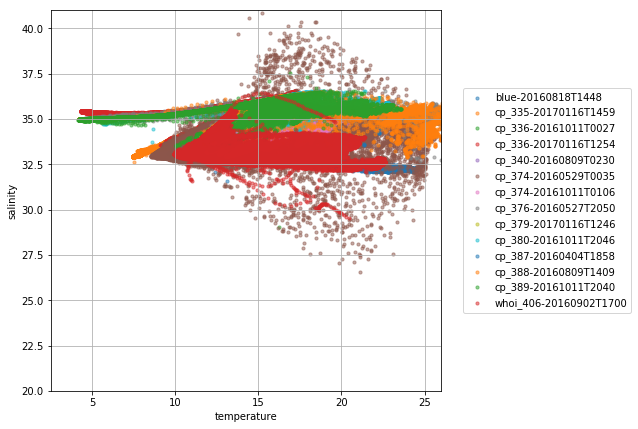

In [23]:
def glider_scatter(df, ax, glider):
    ax.scatter(df['temperature'], df['salinity'],
               s=10, alpha=0.5, label=glider)
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('salinity')
ax.set_xlabel('temperature')
ax.grid(True)

for glider, df in dfs.items():
    glider_scatter(df, ax, glider)
ax.set_ylim(20, 41)
ax.set_xlim(2.5, 26)

ax.legend(bbox_to_anchor=(1.5, 0.5), loc='right');